# Win Probability based on the objectives taken by professional League of Legends teams
This report will outline my mini project for the class "Machine Learning for Media-Experiences" at Aalborg University Copenhagen for the Medialogy Masters class. In this mini project I will be looking at the professional scene of the MOBA game "League of Legends", and thereafter what variables in a game relates to which team winning.

## Background and details about the objectives in the game
In the game of "League of Legends" there are many factors that influence which team wins, each of which are accumulated differently and most of them do no relate. As League of Legends as a game has so many variables, from kills, gold, objectives, champions, individual player skills and so on, it is impossible to get a clear idea of who is gonna win the match or not. In this project, I am gonna try and create a "Win Probability" prediction, in which I will be able to insert different variables into the model to see which team is more likely to win. The data set chosen is a large dataset consisting of every professional match as of the world final (November 19th) and will include matches from both major and minor leagues

# Things to look at
Class applications something to remove bias
Principal component a... (TSNE)
optimizers
every factor relating to it

In [2]:
#|export
import gradio as gr
from fastcore.net import urljson, HTTPError

c:\Users\lukas\OneDrive\Dokumenter\UNI\7th_semester\MLM\ML-For-Beginners\.venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lukas\OneDrive\Dokumenter\UNI\7th_semester\MLM\ML-For-Beginners\.venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\lukas\OneDrive\Dokumenter\UNI\7th_semester\MLM\ML-For-Beginners\.venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
#|export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

In [4]:
#|export
df = pd.read_csv("data/2023_LoL_esports_match_data_from_OraclesElixir.csv")

# Usually you would want to remove the data point if they are empty, however in this case I wanna do the opposite
# I remove all the values that have a player, as I am only interested in the teams performance, not the individual.
df = df[df['playername'].isna()]

# As there are a lot of data in this csv file, I am gonna trim most of them off here.
# Most are related to player specific stats, which we are not that interested in.
# Also some data points that are empty that get removed here
df.drop(columns=['playername', 'playerid', 'firstbloodkill','firstbloodassist','firstbloodvictim','dragons (type unknown)','total cs','monsterkillsownjungle','monsterkillsenemyjungle','teamkills','teamdeaths','damageshare'], inplace=True)
df.drop(columns=['gameid','datacompleteness','url','year','split','playoffs','date','game','patch','participantid','position','teamid','champion'],inplace=True)

# Anything that relates to vision in the game, that while it is an important metric, I chose to remove it as I do not feel it as important as other metrics.
df.drop(columns=['wardsplaced','wpm','wardskilled','wcpm','controlwardsbought','visionscore','vspm'], inplace=True)


df.replace("", float("NaN"), inplace=True) 
df.dropna(how='all',axis=1, inplace=True)

df.head()

C:\Users\lukas\AppData\Local\Temp\ipykernel_26044\348019586.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/2023_LoL_esports_match_data_from_OraclesElixir.csv")


,league,side,teamname,ban1,ban2,ban3,ban4,ban5,gamelength,result,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
10,LFL2,Blue,Klanik Esport,Sylas,Caitlyn,Wukong,Akali,Yone,2612,1,...,535.0,-530.0,-1671.0,-37.0,0.0,0.0,1.0,1.0,1.0,0.0
11,LFL2,Red,MS Company,Galio,Lucian,Fiora,Viktor,Azir,2612,0,...,498.0,530.0,1671.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0
22,LFL2,Blue,beGenius ESC,Fiora,Kindred,Sejuani,Nautilus,Leona,2436,0,...,532.0,673.0,530.0,-34.0,4.0,6.0,3.0,3.0,4.0,4.0
23,LFL2,Red,ViV Esport,Heimerdinger,Wukong,Akali,Syndra,Sylas,2436,1,...,498.0,-673.0,-530.0,34.0,3.0,4.0,4.0,4.0,6.0,3.0
34,LFL2,Blue,Team du Sud,Zac,Sylas,Sejuani,Jarvan IV,Ornn,1980,1,...,452.0,-1901.0,-763.0,58.0,2.0,1.0,4.0,4.0,6.0,2.0


Removing many of the columns that hold unimportant stats for the outcome of the game in general, as well as stats portraying information that is less relevant to the teams performance, there is still a lot of columns. I now choose to focus on the columns that relate to objectives, but I keep the other dataset saved, this way I can always go back and get it if it becomes relevant for something further down the line.

The columns I will be choosing to keep are:
 - Dragons killed per team
 - Rift heralds killed by team
 - Barons killed by team
 - Turrets/inhibitors killed by team

In [28]:
#|export
df_objectives = df.copy()

df_objectives.drop(columns=['league','teamname','ban1','ban2','ban3','ban4','ban5'], inplace=True)
df_objectives.drop(columns=['team kpm','doublekills','triplekills','quadrakills','pentakills','firstblood','ckpm','opp_dragons','opp_elementaldrakes','opp_heralds','opp_elders','opp_barons','opp_towers','opp_turretplates','opp_inhibitors'],inplace=True)
df_objectives.drop(columns=['deaths','assists','elders','heralds','barons','towers','firstmidtower','inhibitors','firsttothreetowers','elementaldrakes','infernals','clouds','mountains','hextechs','oceans','chemtechs'],inplace=True)
df_objectives.drop(columns=['dpm','damagetakenperminute','damagemitigatedperminute','totalgold','earnedgold','earned gpm','earnedgoldshare','goldspent','gspd','minionkills','monsterkills','cspm','goldat10','xpat10','csat10','opp_goldat10','opp_xpat10','opp_csat10','csdiffat10','killsat10','assistsat10','deathsat10','opp_killsat10','opp_assistsat10','opp_deathsat10','goldat15','xpat15','csat15','opp_goldat15','opp_xpat15','opp_csat15','csdiffat15','killsat15','assistsat15','deathsat15','opp_killsat15','opp_assistsat15','opp_deathsat15'], inplace=True)

df_objectives.head()

,side,gamelength,result,kills,firstdragon,dragons,firstherald,firstbaron,firsttower,turretplates,damagetochampions,golddiffat10,xpdiffat10,golddiffat15,xpdiffat15
10,Blue,2612,1,13,0.0,4.0,1.0,1.0,1.0,4.0,95203,75.0,-156.0,-530.0,-1671.0
11,Red,2612,0,7,1.0,3.0,0.0,0.0,0.0,2.0,85333,-75.0,156.0,530.0,1671.0
22,Blue,2436,0,20,0.0,3.0,1.0,1.0,0.0,6.0,106526,-361.0,282.0,673.0,530.0
23,Red,2436,1,16,1.0,4.0,0.0,0.0,1.0,2.0,80368,361.0,-282.0,-673.0,-530.0
34,Blue,1980,1,20,0.0,4.0,0.0,0.0,0.0,3.0,64962,-1001.0,-1748.0,-1901.0,-763.0


In [29]:
#|export
df_objectives.dropna(inplace=True)


In [30]:
#|export
df_objectives_win = df_objectives[df_objectives['result'] == 1]

df_objectives_win.head()

,side,gamelength,result,kills,firstdragon,dragons,firstherald,firstbaron,firsttower,turretplates,damagetochampions,golddiffat10,xpdiffat10,golddiffat15,xpdiffat15
10,Blue,2612,1,13,0.0,4.0,1.0,1.0,1.0,4.0,95203,75.0,-156.0,-530.0,-1671.0
23,Red,2436,1,16,1.0,4.0,0.0,0.0,1.0,2.0,80368,361.0,-282.0,-673.0,-530.0
34,Blue,1980,1,20,0.0,4.0,0.0,0.0,0.0,3.0,64962,-1001.0,-1748.0,-1901.0,-763.0
47,Red,1887,1,14,1.0,4.0,0.0,1.0,0.0,1.0,66869,497.0,-237.0,-504.0,-780.0
58,Blue,2100,1,18,0.0,2.0,0.0,1.0,1.0,4.0,83820,525.0,-920.0,-786.0,-2171.0


This cuts the data set all the way down to 25 columns! Which is a 1/5th of the original dataset, including it already being 1/6th of the rows as well. Lastly I get some information about the dataset, to see which kind of data type each of the rows have.

In [31]:
#|export
# Assuming you have a DataFrame called 'df' with a column 'side' containing "blue" and "red" values
df_objectives['side'] = df_objectives['side'].map({'Blue': 0, 'Red': 1})

df_objectives.head()


,side,gamelength,result,kills,firstdragon,dragons,firstherald,firstbaron,firsttower,turretplates,damagetochampions,golddiffat10,xpdiffat10,golddiffat15,xpdiffat15
10,0,2612,1,13,0.0,4.0,1.0,1.0,1.0,4.0,95203,75.0,-156.0,-530.0,-1671.0
11,1,2612,0,7,1.0,3.0,0.0,0.0,0.0,2.0,85333,-75.0,156.0,530.0,1671.0
22,0,2436,0,20,0.0,3.0,1.0,1.0,0.0,6.0,106526,-361.0,282.0,673.0,530.0
23,1,2436,1,16,1.0,4.0,0.0,0.0,1.0,2.0,80368,361.0,-282.0,-673.0,-530.0
34,0,1980,1,20,0.0,4.0,0.0,0.0,0.0,3.0,64962,-1001.0,-1748.0,-1901.0,-763.0


In [32]:
# Get information about the dataframe
#df.drop(df.columns[[0]], axis=1, inplace=True)
df_objectives.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18448 entries, 10 to 130175
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   side               18448 non-null  int64  
 1   gamelength         18448 non-null  int64  
 2   result             18448 non-null  int64  
 3   kills              18448 non-null  int64  
 4   firstdragon        18448 non-null  float64
 5   dragons            18448 non-null  float64
 6   firstherald        18448 non-null  float64
 7   firstbaron         18448 non-null  float64
 8   firsttower         18448 non-null  float64
 9   turretplates       18448 non-null  float64
 10  damagetochampions  18448 non-null  int64  
 11  golddiffat10       18448 non-null  float64
 12  xpdiffat10         18448 non-null  float64
 13  golddiffat15       18448 non-null  float64
 14  xpdiffat15         18448 non-null  float64
dtypes: float64(10), int64(5)
memory usage: 2.3 MB


In [33]:
# Look at the general values of the data. Note that popularity can be '0' - and there are many rows with that value
df_objectives.describe()

,side,gamelength,result,kills,firstdragon,dragons,firstherald,firstbaron,firsttower,turretplates,damagetochampions,golddiffat10,xpdiffat10,golddiffat15,xpdiffat15
count,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000,18448.000000
mean,0.500000,1882.021032,0.500000,14.253198,0.499892,2.173135,0.499892,0.483955,0.500000,4.421672,72066.266912,0.000000,0.000000,0.000000,0.000000
std,0.500014,337.730404,0.500014,7.447059,0.500014,1.400907,0.500014,0.499756,0.500014,2.570972,25712.522664,1529.013503,999.898851,3055.872078,1902.001484
min,0.000000,976.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14788.000000,-8283.000000,-4717.000000,-17056.000000,-9580.000000
25%,0.000000,1647.000000,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,54025.500000,-962.000000,-625.000000,-1900.250000,-1188.000000
50%,0.500000,1839.000000,0.500000,14.000000,0.000000,2.000000,0.000000,0.000000,0.500000,4.000000,68415.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2080.000000,1.000000,20.000000,1.000000,3.000000,1.000000,1.000000,1.000000,6.000000,86183.250000,962.000000,625.000000,1900.250000,1188.000000
max,1.000000,3604.000000,1.000000,49.000000,1.000000,6.000000,1.000000,1.000000,1.000000,15.000000,227963.000000,8283.000000,4717.000000,17056.000000,9580.000000


In [34]:
#|export
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report

# Assuming you have a DataFrame called 'df' with the team stats and 'result' column indicating the winner (1=win, 0=loss)
# Split the data into training and testing sets
X = df_objectives.drop('result', axis=1)  # Features (team stats)
y = df_objectives['result']  # Target variable (winner)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=2000) # as the data reaches an issue, due to the size of the dataset, I have to set the max iteration up to 2000
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy:", accuracy)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Accuracy: 0.8731707317073171
Mean Squared Error: 0.12682926829268293
R-squared: 0.49256605688518684


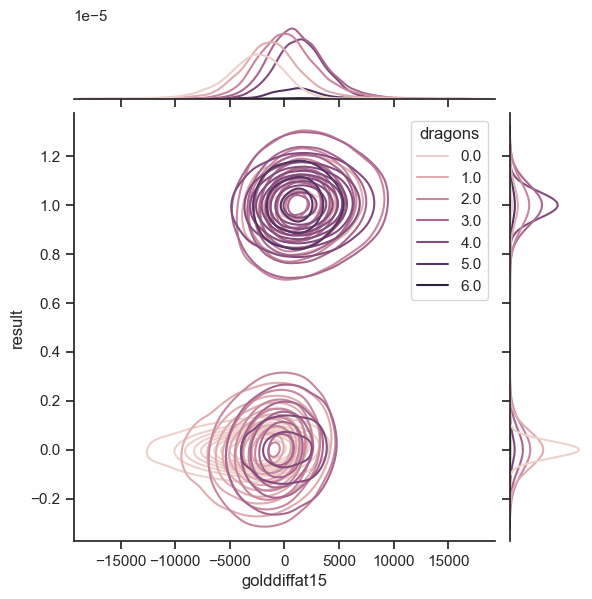

In [36]:
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df,
    x="golddiffat15", y="result", hue="dragons",
    kind="kde",
)

<Axes: xlabel='turretplates', ylabel='golddiffat15'>

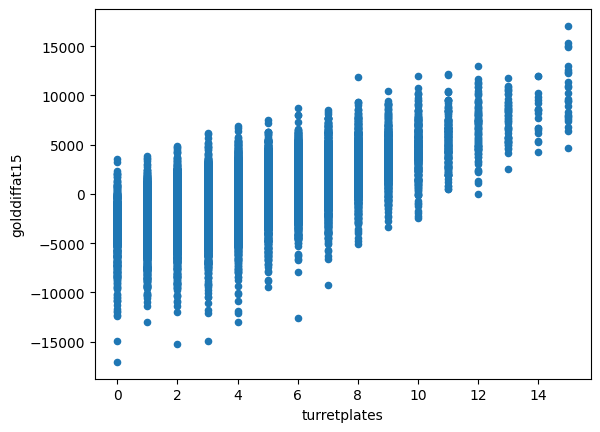

In [24]:
df_objectives.plot.scatter('turretplates','golddiffat15')

In [13]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1817
           1       0.87      0.87      0.87      1873

    accuracy                           0.87      3690
   macro avg       0.87      0.87      0.87      3690
weighted avg       0.87      0.87      0.87      3690



In [14]:
# Assuming you have a DataFrame called 'df' with a column 'side' indicating the side of the game (e.g., 'blue' or 'red')
# and a column 'result' indicating the result of the game (1=win, 0=loss)

# Calculate the total number of games for each side
total_games = df_objectives.groupby('side').size()

# Calculate the number of wins for each side
wins = df_objectives[df_objectives['result'] == 1].groupby('side').size()

# Calculate the win percentage for each side
win_percentage = (wins / total_games) * 100

# Print the win percentage for each side
print(win_percentage)



side
0    53.415004
1    46.584996
dtype: float64


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

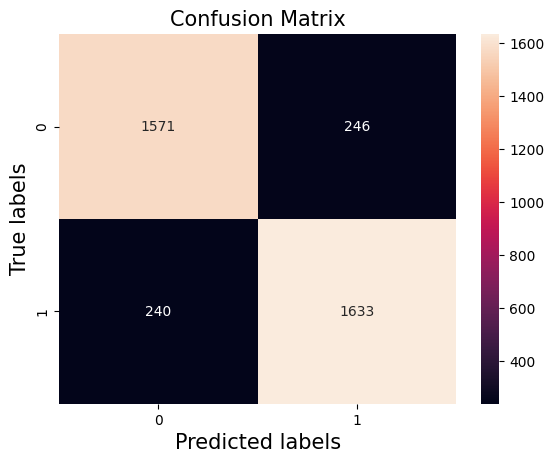

Prediction accuracy: 86.83%


In [16]:
def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)

y_pred = model.predict(X_test)
generate_confusion_matrix(y_test, y_pred)
plt.show()

# compute the accuracy
multi_accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")

<Axes: >

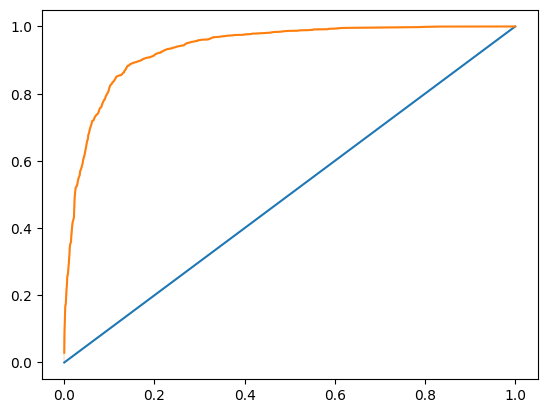

In [17]:
y_scores = model.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

sns.lineplot(x=[0, 1], y=[0, 1])
sns.lineplot(x=fpr, y=tpr)

In [18]:
from sklearn.svm import SVC

C = 3
# Create different classifiers.
classifiers = {
    'Linear SVC (low regularization, low iteration)': SVC(kernel='linear', C=C, max_iter=1000, probability=True,random_state=0),
    
    #'RFST': RandomForestClassifier(n_estimators=100),
    #'ADA': AdaBoostClassifier(n_estimators=100)  
}

import warnings
# Filter out user warnings due to SVC and KNN usesr warnings
warnings.filterwarnings("ignore", category=UserWarning)

n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))
    X_test = np.ascontiguousarray(X_test) # fixes KNN c_contiguous array error
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Linear SVC (low regularization, low iteration): 66.9% 
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1817
           1       0.65      0.75      0.70      1873

    accuracy                           0.67      3690
   macro avg       0.67      0.67      0.67      3690
weighted avg       0.67      0.67      0.67      3690



In [19]:
from sklearn.neighbors import KNeighborsClassifier

C = 10
# Create different classifiers.
classifiers = {
    'KNN classifier1': KNeighborsClassifier(n_neighbors=C, leaf_size=30, p=1),
    #'SVC': SVC(),
    #'RFST': RandomForestClassifier(n_estimators=100),
    #'ADA': AdaBoostClassifier(n_estimators=100)  
}

import warnings
# Filter out user warnings due to SVC and KNN usesr warnings
warnings.filterwarnings("ignore", category=UserWarning)

n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))
    X_test = np.ascontiguousarray(X_test) # fixes KNN c_contiguous array error
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for KNN classifier1: 76.4% 
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1817
           1       0.77      0.77      0.77      1873

    accuracy                           0.76      3690
   macro avg       0.76      0.76      0.76      3690
weighted avg       0.76      0.76      0.76      3690



In [20]:
# ONNX EXPORT

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, 380]))]
# ** Note the options: nocl: no class info embedded (smaller filesize). zipmap: list of dictionaries
options = {id(model): {'nocl': True, 'zipmap': False}}

onx = convert_sklearn(model, initial_types=initial_type, options=options)
with open("./model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

ModuleNotFoundError: No module named 'skl2onnx'

In [ ]:
from nbdev.export import nb_export
nb_export('MiniProject.ipynb', lib_path='.', name='League_WinProbability_2023')

In [ ]:
%pycat League_WinProbability_2023.py

# AUTOGENERATED! DO NOT EDIT! File to edit: MiniProject.ipynb.

# %% auto 0
__all__ = []

# %% MiniProject.ipynb 21
import gradio as gr
from fastcore.net import urljson, HTTPError


In [ ]:
%%writefile requirements.txt
fastcore

Overwriting requirements.txt


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=3,
    init="random",
    random_state=20150101,
    perplexity=30,
    learning_rate="auto",
    n_iter=300,
)

In [ ]:
#import wandb